In [3]:
import sys
import os
import pymesh
from Bio.PDB import PDBParser
from proemb.utils import surface_util
from proemb.utils.surface_util import protein_letters_1to3_extended
import glob
import seaborn as sns
import pickle

import numpy as np
import pandas as pd

from Bio import SCOP
import tqdm
import pickle as pkl

import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import scipy.stats as st
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [ ]:
remote = False
base = '../../data/' if not remote else '/scratch/ii1g17/protein-embeddings/data/'
root = f'{base}SCOPe/pdbstyle-2.06-structures-radius-1.4-no-HETATM'
scop_ply_paths = sorted(glob.glob(f'{root}{os.sep}*{os.sep}*.ply'))
scop_surface_indexes = {os.path.basename(path).split('.ply')[0]: path for path in scop_ply_paths}
scop_db = SCOP.Scop(dir_path=f"{base}SCOPe", version="2.06")
parser = PDBParser(QUIET=True)

scop_id_dict = {}
for SCOP_ID in tqdm.tqdm(scop_surface_indexes.keys(), total=len(scop_surface_indexes.keys())):


    path = scop_surface_indexes[SCOP_ID]
    hierarchy = scop_db.getDomainBySid(SCOP_ID).toClaRecord().hierarchy
    class_name = scop_db.getNodeBySunid(int(hierarchy["cl"])).description
    fold_name = scop_db.getNodeBySunid(int(hierarchy["cf"])).description

    try:
        surface_mesh = pymesh.load_mesh(path)
        struct_path = path.split('.ply')[0] + '.ent'
        struct = parser.get_structure(struct_path, struct_path)[0]
    except OSError as e:
        continue

    residues_depth = surface_util.residues_depth(struct, surface_mesh.vertices, ignore_disordered=False)
    rsasa = surface_util.residue_solvent_accessible_surface_area(struct, ignore_disordered=False)

    aa_infos = {}
    aa_infos['CLASS-TYPE'] = class_name
    aa_infos['FOLD-TYPE'] = fold_name
    aa_infos['DIST'] = [depth[0] for depth in list(residues_depth.values())] # residue depth
    aa_infos['RSASA'] = list(rsasa.values())
    aa_infos['1-LET-AA'] = [res[2] for res in list(residues_depth.keys())] #already grouped by residue depth
    aa_infos['3-LET-AA'] = [protein_letters_1to3_extended[aa] for aa in list(aa_infos['1-LET-AA'])]
    aa_infos['ROSE-TYPE'] = [surface_util.ROSE_AA[aa] for aa in list(aa_infos['3-LET-AA'])]

    scop_id_dict[SCOP_ID] = aa_infos

# save the results as pickle
with open('scop_id_DIST_RSASA_SHAPE-2.06-no-HETATM-1.4-radius.pkl', 'wb') as f:
    pkl.dump(scop_id_dict, f)

with open('results/scop_id_DIST_RSASA_SHAPE-2.06-no-HETATM-1.4-radius.pkl', 'rb') as f:
    scop_id_dict = pickle.load(f)

aa_info_dataframe = pd.DataFrame(data=scop_id_dict.values())
aa_info_dataframe.insert(0, 'SCOP_ID', scop_id_dict.keys())
#apply series explode
aa_info_dataframe = aa_info_dataframe.apply(lambda x: x.explode() if x.name in ['DIST', 'RSASA', '1-LET-AA', '3-LET-AA', 'ROSE-TYPE'] else x)
aa_info_dataframe.to_csv('results/scop_id_DIST_RSASA_SHAPE-2.06-no-HETATM-1.4-radius.csv')

### Loading data

In [4]:
aa_info_df = pd.read_csv('results/pickles-data/scop_id_DIST_RSASA_SHAPE-2.06-no-HETATM-1.4-radius.csv')

# change XAA to UNK
aa_info_df['3-LET-AA'] = aa_info_df['3-LET-AA'].replace('XAA', 'UNK')
# adding the ALL grouping
aa_info_no_all = aa_info_df
aa_info_no_all['SEQ-POS'] = aa_info_no_all.groupby('SCOP_ID').cumcount()

doubled_df = pd.concat([aa_info_df, aa_info_df], ignore_index=True)
doubled_df['ROSE-TYPE'] = list(aa_info_df['ROSE-TYPE']) + list(['ALL'] * len(aa_info_df))
doubled_df['3-LET-AA'] = list(aa_info_df['3-LET-AA']) + list(['ALL'] * len(aa_info_df))
aa_info_df = doubled_df

In [5]:
# surfaces which could not bring together chain breaks
# all the structures with nr. residue depth > 10 were manually checked
# if a structure had a break and the nr of residues with rd>10 was greater than 4
broken_surf = ["d1urja_", "d2yhea1", "d4wyoc2", "d3r1ma_", "d1k8kc_", "d2bnxa1", "d2nz6a1", "d3srya_",              "d3c98b_",
               "d1sp9b2", "d2axzc2", "d2q8ga2", "d2fm8c1", "d4nzpa2", "d3cx8b_", "d3ptaa4",
               "d4urpa_", "d2e50a1", "d4mcba_", "d1dkva6", "d1p9pa_", "d3ky7a_", "d2qe7g_", "d1ut7a_", "d1rnja_",
               "d1a6ja_", "d3fdsd1", "d1i2ha1", "d3mi9b2", "d1r9ja3", "d4ihje_", "d4lhpa_", "d1igna2", "d1hl6a_",
               "d1ebda2", "d1cr9h1", "d3bw1a1", "d2e3ia_", "d2bkid_", "d1b72a_", 'd1oy5a_', "d2pw8i1", "d3quva1",
               "d3knua1", 'd2wela_', 'd3e2qa1', "d1hbxg_", "d3e3ia_", 'd3g4da1', "d3zrsa1", "d4asui_", "d2b9va2",
               'd1z84a1', 'd1m2vb2', "d3ab3b_", "d1l3ac1", "d3begb_", "d4leja2", 'd4feva_', 'd5c8ca_', "d5c8ca_",
               'd1z19a_', 'd3u84b2', 'd2vz5a1', 'd2hld1_', 'd1vj7a2', 'd3mdxa_', 'd1b8ia_', 'd1tmf.1', 'd1tf5a3',
               'd1i6vd_', 'd1aym.1', 'd4hb2b_', 'd1r1a.1', 'd1fpn.1', 'd2yi9a1',
               'd3dyda_', 'd4ihja2', 'd1t0hb_', 'd2p0sa1', 'd1smsa_',
               'd2pqqa1', 'd4p7sa_', 'd3tq7a_', 'd2d3ia2', 'd3tq7b_',
               'd1hxs1_']

## Plot amino acid distributions

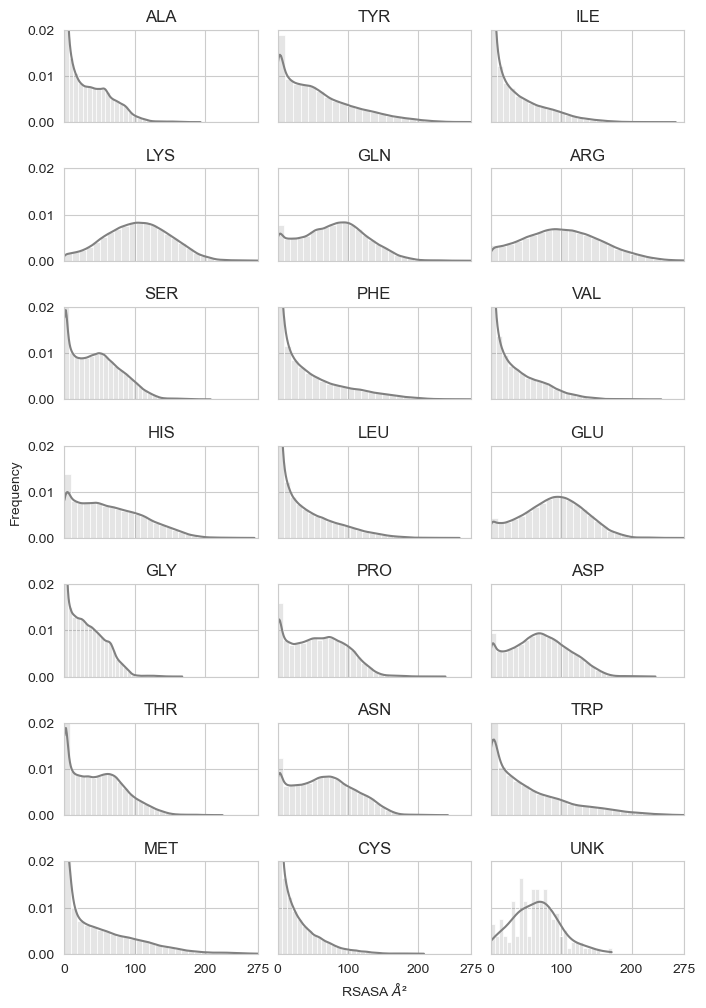

In [6]:
filtered_df = aa_info_no_all[~aa_info_no_all['SCOP_ID'].isin(broken_surf)]
df = pd.DataFrame(data=filtered_df[['RSASA', '3-LET-AA', 'ROSE-TYPE']])
sns.set_style("whitegrid")
# Create a normalized histogram for each amino acid type
aa_types = df['3-LET-AA'].unique()
aa_types = [aa for aa in aa_types if aa != 'ALL']
fig, axs = plt.subplots(7, 3, figsize=(8, 12),
                        gridspec_kw={'hspace': 0.5, 'wspace': 0.1})
axs = axs.ravel()
for i, aa in enumerate(aa_types):
    aa_df = df[df['3-LET-AA'] == aa]
    sns.histplot(aa_df['RSASA'], kde=True, bins=30,
                 ax=axs[i], color='grey', alpha=0.2, stat='density',linewidth=0.5)
    axs[i].set_title(aa)
    axs[i].set_ylabel("")
    axs[i].set_xlabel("")
    axs[i].set_xlim(0, 275) # set x axis limit
    axs[i].set_ylim(0, 0.02) # set x axis limit

    if i in range(0, 21, 3):
        axs[i].set_yticks([0.00, 0.01, 0.02])
    else:
        axs[i].set_yticks([0.00, 0.01, 0.02])
        axs[i].set_yticklabels([])

    if i in [18,19,20]:
        axs[i].set_xticks([0, 100, 200, 275])
    else:
        axs[i].set_xticks([0, 100, 200, 275])
        axs[i].set_xticklabels([])

    if i == 9:
        axs[i].set_ylabel("Frequency")
    if i == 19:
        axs[i].set_xlabel("RSASA $\AA$\N{SUPERSCRIPT TWO}")
#plt.savefig('results/residue-rsasa-histogram-pdbstyle-2.06-no-HETATM-1.4-radius.pdf', bbox_inches='tight', dpi=300)
plt.show()

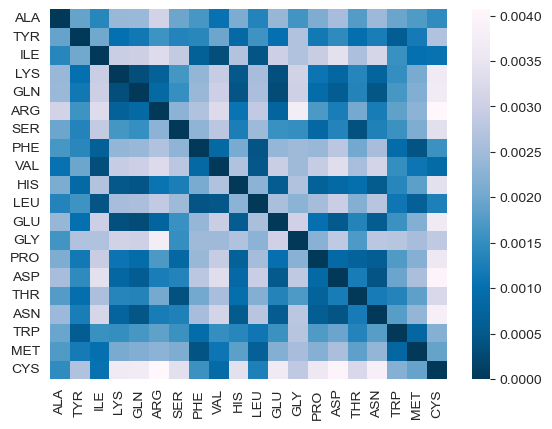

In [7]:
filtered_df = aa_info_no_all[~aa_info_no_all['SCOP_ID'].isin(broken_surf)]
df = pd.DataFrame(data=filtered_df[['RSASA', '3-LET-AA', 'ROSE-TYPE']])
# Bin the data for each amino acid into a histogram
aa_types = df['3-LET-AA'].unique()
aa_types = [aa for aa in aa_types if aa != 'ALL' and aa!= 'UNK']
bins = 30
area_cutoff = 275
histograms = {}
for aa in aa_types:
    aa_df = df[df['3-LET-AA'] == aa]
    histograms[aa], _ = np.histogram(aa_df[aa_df['RSASA'] <= area_cutoff]['RSASA'], bins=bins, density=True)

# Calculate the KL divergence between each pair of amino acids
wass = np.zeros((len(aa_types), len(aa_types)))
for i in range(len(aa_types)):
    for j in range(len(aa_types)):
        aa1 = aa_types[i]
        aa2 = aa_types[j]
        wass[i][j] = st.wasserstein_distance(histograms[aa1], histograms[aa2])

# Plot the KL divergence matrix as a heatmap
sns.heatmap(wass, xticklabels=aa_types, yticklabels=aa_types, cmap='PuBu_r')
#plt.savefig('results/residue-rsasa-wasserstain-pdbstyle-2.06-no-HETATM-1.4-radius.pdf', bbox_inches='tight', dpi=300)
plt.show()

/var/folders/0t/xsc02g1j6z79zd6mkph9lh980000gp/T/ipykernel_89819/2357362621.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(wass, method='centroid')


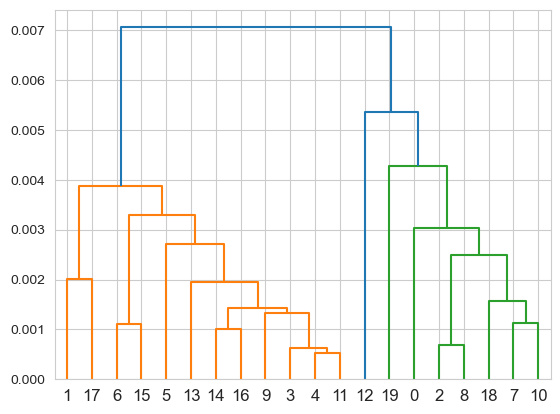

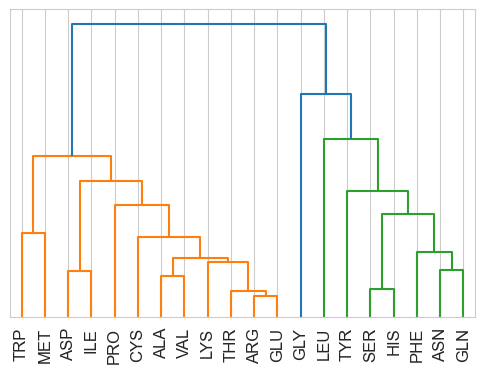

In [8]:
sns.set_style("whitegrid")
# calculate the linkage matrix
linkage_matrix = sch.linkage(wass, method='centroid')

# plot the dendrogram
dendrogram = sch.dendrogram(linkage_matrix);

# get the leaf indices of the dendrogram
leaf_indices = dendrogram['leaves']

# get the labels for the leaves
labels = [aa_types[i] for i in leaf_indices]

# plot the dendrogram with labels
plt.figure(figsize=(6, 4))
sch.dendrogram(linkage_matrix, labels=labels)
plt.xticks(rotation=90)
plt.yticks([])
#plt.savefig('results/275-centroid-residue-rsasa-dendrogram-pdbstyle-2.06-no-HETATM-1.4-radius.pdf', bbox_inches='tight', dpi=300)
plt.show()

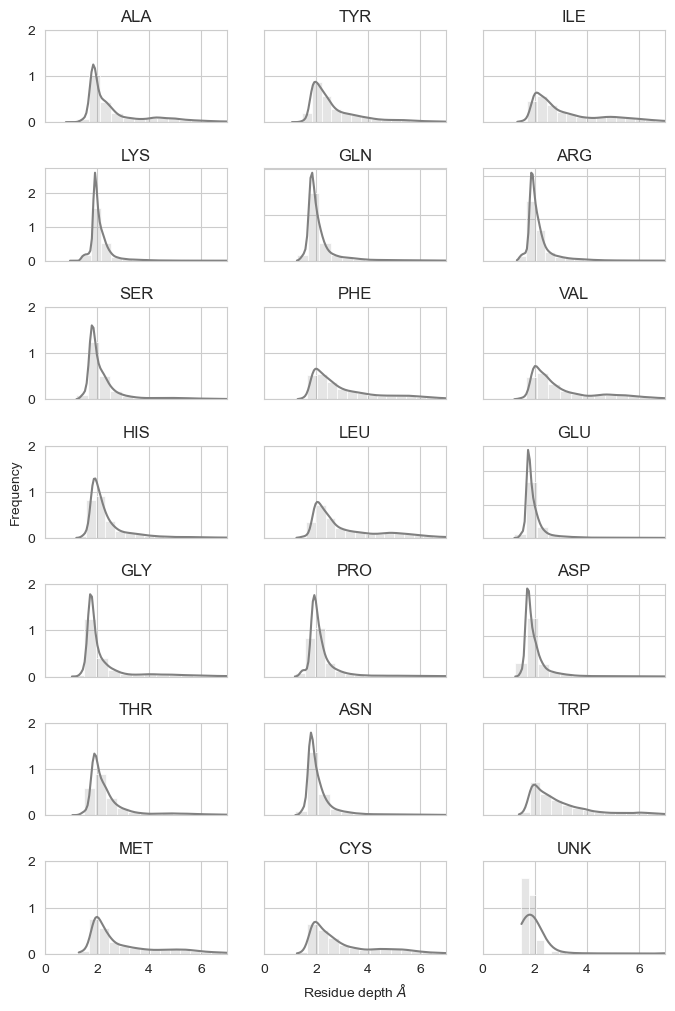

In [9]:
filtered_df = aa_info_no_all[~aa_info_no_all['SCOP_ID'].isin(broken_surf)]
df = pd.DataFrame(data=filtered_df[['DIST', '3-LET-AA', 'ROSE-TYPE']])
sns.set_style("whitegrid")
# Create a normalized histogram for each amino acid type
aa_types = df['3-LET-AA'].unique()
aa_types = [aa for aa in aa_types if aa != 'ALL']
fig, axs = plt.subplots(7, 3, figsize=(8, 12),
                        gridspec_kw={'hspace': 0.5, 'wspace': 0.2})
axs = axs.ravel()
for i, aa in enumerate(aa_types):
    aa_df = df[df['3-LET-AA'] == aa]
    sns.histplot(aa_df['DIST'], kde=True, bins=30,
                 ax=axs[i], color='grey', alpha=0.2, stat='density',linewidth=0.5)
    axs[i].set_title(aa)
    axs[i].set_ylabel("")
    axs[i].set_xlabel("")
    axs[i].set_xlim(0, 7) # set x axis limit
    #axs[i].set_ylim(0, 1.4) # set x axis limit

    if i in range(0, 21, 3):
        axs[i].set_yticks([0.0, 1.0, 2])
    else:
        axs[i].set_yticks([0.0, 1.0, 2])
        axs[i].set_yticklabels([])

    if i in [18,19,20]:
        axs[i].set_xticks([0, 2, 4, 6])
    else:
        axs[i].set_xticks([0, 2, 4, 6])
        axs[i].set_xticklabels([])

    if i == 9:
        axs[i].set_ylabel("Frequency")
    if i == 19:
        axs[i].set_xlabel("Residue depth $\AA$")
plt.savefig(f'results/residue-depth-7-cutoff-histogram-pdbstyle-2.06-no-HETATM-1.4-radius.pdf', bbox_inches='tight', dpi=300)
plt.show()